In [1]:
import os

# get working directory
#os.getcwd()

os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import pathlib

import get_voting_scores as gvs

In [3]:
import pathlib
DATAPATH = pathlib.Path().resolve().parent / "data"

In [4]:
# Get the voting scores
df = gvs.get_voting_scores(DATAPATH / "eurovision_voting_scores_1975_2019.xlsx")


In [5]:
df= df.replace({pd.NA: np.nan})

def sum_values(vals):
    # if all nan, then set as nan
    if np.all(np.isnan(vals)):
        return np.nan
    else:
        return vals.sum()

# for each country and year, get the sum values
df_plot = df.groupby(['Year', 'To country'])['Votes'].agg(sum_values).reset_index()

# Add column for the country position for each year - this may differ slightly 
# from official results in later year (due to ties)
df_plot['Position'] = df_plot.groupby('Year')['Votes'].rank(ascending=False)


In [71]:
import seaborn as sns
sns.set_theme(style="whitegrid")

my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: (y) / (26)

def plot_country(country, ax):
    df_temp = df_plot.loc[df_plot['To country'] == country]

    # add dummy data for years not included in the data
    missing_years = list(set(range(1997, 2023)) - set(df_temp['Year']))

    # for year in missing_years:
    #     dummy = pd.DataFrame([year, country, np.nan, np.nan]).T
    #     dummy.columns = ['Year', 'To country', 'Votes', 'Position',]
    #     df_temp = pd.concat([df_temp, dummy]) 

    # sort by year
    df_temp = df_temp.sort_values('Year', ascending=False)    
    df_temp['Position'] = df_temp['Position'].astype(float)

    # matplotlib bar chart
    ax.bar(df_temp['Year'], df_temp['Votes'], 
            color=my_cmap(rescale(df_temp['Position'])))


    ax.scatter(2020, 10, s=25, color='grey', marker="_")

    # annotate if nan (did not perform)
    for i, v in enumerate(df_temp['Votes']):
        if np.isnan(v):
            ax.scatter(df_temp['Year'].iloc[i], 10, s=25, color='grey', marker="x")


    winner = df_temp.loc[df_temp['Position'] == 1]
    if winner.shape[0] > 0:
        ax.scatter(winner['Year'].iloc[0], winner['Votes'].iloc[0], s=50, 
                   color='gold', marker="*", edgecolor='black', zorder=5)
    
    country_name = pycountry.countries.get(alpha_2=country).name
    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)


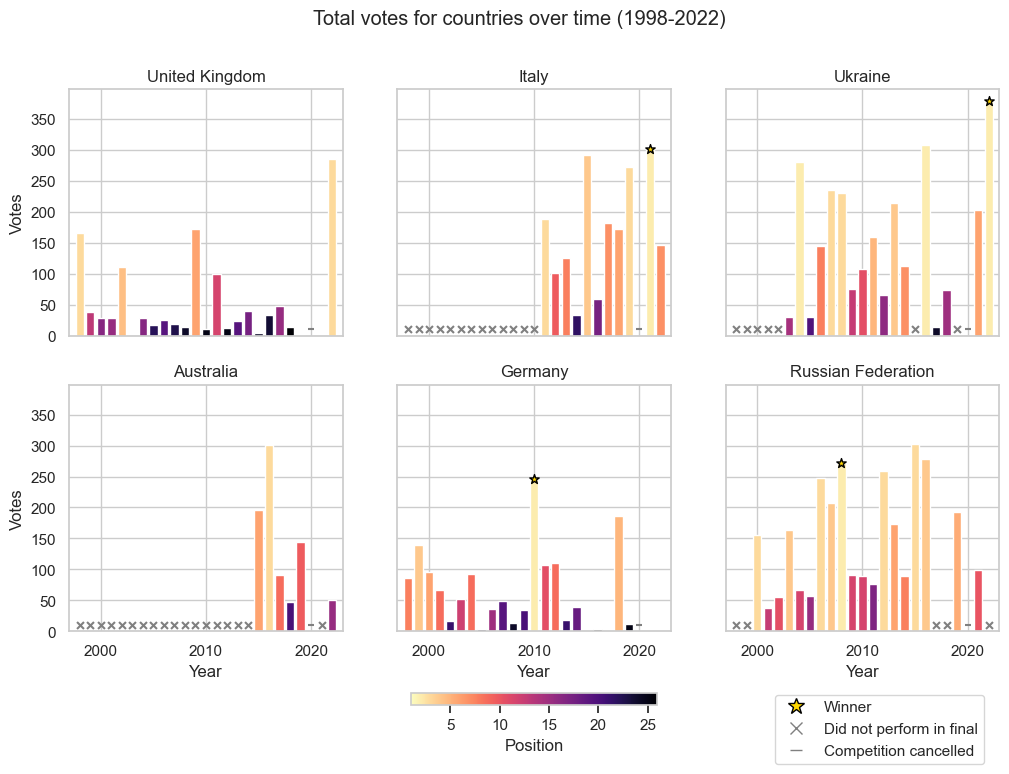

In [72]:
# create a bar chart for GB coloured by winner
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True, squeeze=True)

plot_country('GB', ax[0, 0])
plot_country('IT', ax[0, 1])
plot_country('UA', ax[0, 2])
plot_country('AU', ax[1, 0])
plot_country('DE', ax[1, 1])
plot_country('RU', ax[1, 2])

ax[1,0].set_xlabel('Year')
ax[1,1].set_xlabel('Year')
ax[1,2].set_xlabel('Year')
ax[0,0].set_ylabel('Votes')
ax[1,0].set_ylabel('Votes')

# add a legend for my_cmap
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position')

# add a legend for the winner
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='center', ncol=1, bbox_to_anchor=(0.8, 0.08))

# add title
fig.suptitle('Total votes for countries over time (1998-2022)')

plt.show()